# Text Clustering 

## Dataset - 20 Newspapers - Sklearn

## Goal: Text Clustering and Evaluate the algorithm

In [1]:
!pip install nltk

In [2]:
!pip install wordcloud

## Importing Libraries

In [3]:
import re
import math
import string

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

#Dataset
from sklearn.datasets import fetch_20newsgroups

# NLTk Imports
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

#Visualization Imports
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

## Load the Dataset

In [4]:
orig_dataset = fetch_20newsgroups(subset="all", shuffle=True, random_state=42)

In [5]:
# Print Info about the dataset
print(f"This dataset contains {len(orig_dataset.data)} documents and {len(orig_dataset.target_names)} categories.")

This dataset contains 18846 documents and 20 categories.


In [6]:
# Using seed to find the same results each time
np.random.seed(40)

In [7]:
# Dividing the Dataset into data and target variables - This will help us to cluster the data without any bias (from the target variable)

orig_data = orig_dataset.data
orig_target = orig_dataset.target_names

In [8]:
print(orig_data[1])

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   



In [9]:
print(orig_data[2])

From: hilmi-er@dsv.su.se (Hilmi Eren)
Subject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)
Lines: 95
Nntp-Posting-Host: viktoria.dsv.su.se
Reply-To: hilmi-er@dsv.su.se (Hilmi Eren)
Organization: Dept. of Computer and Systems Sciences, Stockholm University




|>The student of "regional killings" alias Davidian (not the Davidian religios sect) writes:


|>Greater Armenia would stretch from Karabakh, to the Black Sea, to the
|>Mediterranean, so if you use the term "Greater Armenia" use it with care.


	Finally you said what you dream about. Mediterranean???? That was new....
	The area will be "greater" after some years, like your "holocaust" numbers......




|>It has always been up to the Azeris to end their announced winning of Karabakh 
|>by removing the Armenians! When the president of Azerbaijan, Elchibey, came to 
|>power last year, he announced he would be be "swimming in Lake Sevan [in 
|>Armeniaxn] by July".
		*****
	Is't July in USA now????? Here in Sweden it's

From above, we can say that these data are in an Email format containing all the relevant details

In [10]:
print(orig_target)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [11]:
### From above, we can say that these data are in an Email format containing all the relevant details
### 

## Restricting the categories to 3 to increase the computational power

In [12]:
categories = ['comp.windows.x', 'rec.sport.hockey', 'talk.religion.misc']

In [13]:
print(f'Using categories : {categories}')
print('#' * 80)
  
dataset = fetch_20newsgroups(subset="all", categories=categories, shuffle=True, random_state=42)

# Print Info about the dataset
print(f"The condensed dataset contains {len(dataset.data)} documents and {len(dataset.target_names)} categories.")

# Dividing the Dataset into data and target variables - This will help us to cluster the data without any bias (from the target variable)
data = dataset.data
target = dataset.target_names
print('#' * 80)
print(data[1])
print('#' * 80)

Using categories : ['comp.windows.x', 'rec.sport.hockey', 'talk.religion.misc']
################################################################################
The condensed dataset contains 2615 documents and 3 categories.
################################################################################
From: seth@cbnewsh.cb.att.com (peter.r.clark..jr)
Subject: Re: Flyers [Re: This year's biggest and worst (opinion)...]
Organization: AT&T
Distribution: na
Keywords: NHL, awards
Lines: 80

In article <1993Apr14.165617.3215@cbnewsm.cb.att.com>, jmd@cbnewsm.cb.att.com (joseph.m.dakes) writes:
> In article <1993Apr13.144030.28994@cbnewsh.cb.att.com>, seth@cbnewsh.cb.att.com (peter.r.clark..jr) writes:
> 
> >So Roussel was giving up almost another goal a game while facing a proportional
> >number of shots for the number of minutes he played, and while I have't
> >actually checked I believe that he faced a lower quality of opponent.
> 
> Make that less than half a goal a game.  The lower qua

In [14]:
#load_dataset_with_less_categories(categories, data, target)

# Preprocessing

In [15]:
# Lemmantization
lemmatizer = WordNetLemmatizer()
for i in range(len(data)):
    word_list = word_tokenize(data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    data[i] = lemmatized_doc.casefold() # Using Casefold for extreme text lowering

In [16]:
# Note: The above computation was taking a lot of time to execute. Hence, I have not removed the punctuations in this dataset.

In [17]:
print(data[1])

 from : seth @ cbnewsh.cb.att.com ( peter.r.clark .. jr ) subject : re : flyers [ re : this year 's biggest and worst ( opinion ) ... ] organization : at & t distribution : na keywords : nhl , award lines : 80 in article < 1993apr14.165617.3215 @ cbnewsm.cb.att.com > , jmd @ cbnewsm.cb.att.com ( joseph.m.dakes ) writes : > in article < 1993apr13.144030.28994 @ cbnewsh.cb.att.com > , seth @ cbnewsh.cb.att.com ( peter.r.clark .. jr ) writes : > > > so roussel wa giving up almost another goal a game while facing a proportional > > number of shot for the number of minute he played , and while i have't > > actually checked i believe that he faced a lower quality of opponent . > > make that le than half a goal a game . the lower quality of opponet > argument is immaterial a neither roussel nor soderstrom had any say in > the matter . that wa dineen 's decision . so in other word , if roussel shuts out the sharks and soderstrom shuts out the penguins , that 's immaterial because it wa the coa

In [18]:
#Using TFVectorizer on the data
print("Using TFVectorizer on the data.")

vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2)
#vectorizer = TfidfVectorizer(stop_words='english', preprocessor=preprocessing)
data_vect_transformed = vectorizer.fit_transform(data)
data_vect_transformed.shape

Using TFVectorizer on the data.


(2615, 20828)

In [19]:
print(vectorizer.get_feature_names())

['00', '000', '0000vec', '0001', '001102', '002509', '0033', '004331', '005', '0060', '0062', '0068', '007', '0086', '01', '0100', '010329', '010734', '010900rap115', '011', '0112', '012', '0123456789', '013939', '015415', '01803', '02', '0200', '0209', '02139', '02142', '02154', '022113', '0223', '0226', '0228', '023650', '025426', '0286', '02956996', '03', '030', '0300', '031', '031823', '032017', '033', '04', '0400', '043426', '044323', '0444', '0446', '044749', '04q', '05', '050', '0500', '051', '0511', '051942', '052120rap115', '0526189607', '053748rap115', '0539', '054446', '06', '060010', '0608', '0615', '062622', '063836', '065', '0666', '06paul', '07', '0700', '070706', '071', '071791', '0739', '074054', '074840librba', '077', '08', '082502acps6992', '085337', '085435', '0881', '08836', '089', '09', '0908', '092246dlmqc', '092830', '0936', '093914', '0950', '0965', '0a', '0am', '0aw', '0b', '0d', '0f', '0frolv200awvi3iv4s', '0g', '0h', '0ha', '0i', '0j', '0l', '0m', '0o', '0p'

## Fitting the Model

In [20]:
# As per our knowledge, we have 3 categorieds of data. 
# Either we can use this as a baseline for our k (number of cluster) or choose a range between 3 to 6.

In [21]:
# Fitting the model
number_of_clusters = 3

Kmeans_cls = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100,
               n_init=1) 

model = Kmeans_cls.fit(data_vect_transformed)
model_label = model.labels_
print(f'Model labels: {model_label}')

Model labels: [1 1 2 ... 0 1 0]


In [22]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

print(terms[5000:5500])

['cheek', 'cheer', 'cheering', 'cheers', 'cheese', 'cheevers', 'chef', 'chelios', 'chelioses', 'chem', 'chemical', 'chemistry', 'cheng', 'cherbayev', 'cherry', 'chest', 'chesterton', 'cheveldae', 'chevron', 'chevy', 'chew', 'chhabra', 'chheda', 'chi', 'chia', 'chiasson', 'chicago', 'chicken', 'chico', 'chief', 'chiefs', 'child', 'childbirth', 'children', 'chile', 'chill', 'chimpanzee', 'chin', 'china', 'chinese', 'ching', 'chip', 'chippy', 'chips', 'chipset', 'chipsets', 'chl', 'chmod', 'cho', 'chocolate', 'choice', 'choke', 'choked', 'choking', 'cholesterol', 'chonglab', 'chongo', 'choose', 'chooser', 'chooses', 'choosing', 'chop', 'chopin', 'chopped', 'choppy', 'chorion', 'chorske', 'chose', 'chosen', 'chou', 'chown', 'chpc', 'chris', 'chris_chelios', 'chris_roney', 'christ', 'christanity', 'christian', 'christian_ruuttu', 'christianity', 'christians', 'christmas', 'christophe', 'christopher', 'christy', 'chronic', 'chronicles', 'chronological', 'chronology', 'chu', 'chubby', 'chuck'

In [23]:
for i in range(number_of_clusters):
    print(f'The top 10 words in the Cluster {i} are given below:'),
    for ind in order_centroids[i, :10]:
        print(f'{terms[ind]}')

The top 10 words in the Cluster 0 are given below:
window
com
edu
server
mit
motif
file
subject
widget
lines
The top 10 words in the Cluster 1 are given below:
game
edu
team
ca
wa
hockey
player
year
play
university
The top 10 words in the Cluster 2 are given below:
god
com
edu
sandvik
wa
jesus
christian
people
say
writes


### Deductions
1. Cluster 0 groups the data in terms of computer hardware.
2. Cluster 1 groups the data in terms of game and the place where it is played.
3. Cluster 2 groups the data in terms of god or religion.
    
Hence, we can say that the created clusters corresponds to the original categories given below: 
'comp.windows.x', 'rec.sport.hockey', 'talk.religion.misc'.

## Creating Visualizations using WordCloud

In [24]:
def frequencies_dict(cluster_index):
    """A function to return frequencies based on cluster centres and cluster centroids"""
    if cluster_index > number_of_clusters - 1:
        return
    term_frequencies = model.cluster_centers_[cluster_index]
    sorted_terms = order_centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

def makeImage(frequencies):
    """A function to create and plot the wordcloud, 
    internally using generate_from_frequencies function of wordclound."""
    wc = WordCloud(width=1000, height=600 , background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


WordCloud with top 50 words in the Cluster 0 are: 


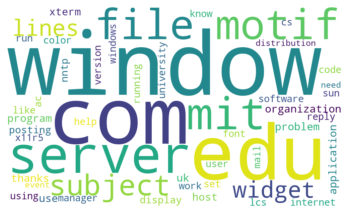

################################################################################
WordCloud with top 50 words in the Cluster 1 are: 


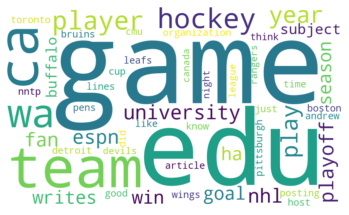

################################################################################
WordCloud with top 50 words in the Cluster 2 are: 


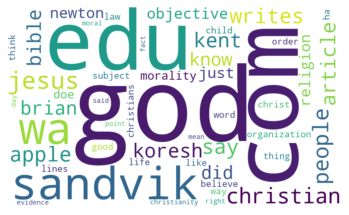

################################################################################


In [25]:
for i in range(3):
    print(f"WordCloud with top 50 words in the Cluster {i} are: ")
    freq = frequencies_dict(i)
    makeImage(freq)
    print('#'*80)

In [26]:
print(f'Original categoiries were : {categories}')

Original categoiries were : ['comp.windows.x', 'rec.sport.hockey', 'talk.religion.misc']


In [27]:
#print("Silhouette Coefficient: %0.3f"  % silhouette_score(data_vect_transformed, model_label, sample_size=500))

## Evaluating the Algorithm

### Note:
1. Decreasing the WCSS is the key objective of K-Means clustering.
2. In addition to it, Silhouette coefficient should be nearer to +1.

In [28]:
wcss = [] # to store wcss scores
sil_scores = [] # to store silhoute scores
#calinski_score = []
#davies_score = []
no_of_cluster = 10
cluster_index = range(2, no_of_cluster+1) # Using Number of clusters from 2 to 10.

for i in cluster_index:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(data_vect_transformed)
    
    #Within Cluster Sum of Square
    inertia_or_wcss= kmeans.inertia_
    wcss.append(inertia_or_wcss)
    #Silhoute Score
    sil_score = silhouette_score(data_vect_transformed, labels,  sample_size=1000) # Using small sample size as the kernal is getting dead.
    sil_scores.append(sil_score)
    
    #calinski_score.append(calinski_harabasz_score(data_vect_transformed.toarray(), labels,  sample_size=500))
    #davies_score.append(davies_bouldin_score(data_vect_transformed, labels))
 
    print('Inertia or WCSS at K =', i, ':', inertia_or_wcss)
    print("Silhouette Coefficient: %0.5f" % sil_score)
    #print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))
   # print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, labels))
    print("---------------------------------------------------------------")

Inertia or WCSS at K = 2 : 2543.3791203892356
Silhouette Coefficient: 0.00730
---------------------------------------------------------------
Inertia or WCSS at K = 3 : 2528.419186315933
Silhouette Coefficient: 0.00886
---------------------------------------------------------------
Inertia or WCSS at K = 4 : 2518.7695610991655
Silhouette Coefficient: 0.00774
---------------------------------------------------------------
Inertia or WCSS at K = 5 : 2507.50423338607
Silhouette Coefficient: 0.00768
---------------------------------------------------------------
Inertia or WCSS at K = 6 : 2501.0207407575213
Silhouette Coefficient: 0.00699
---------------------------------------------------------------
Inertia or WCSS at K = 7 : 2495.13579367666
Silhouette Coefficient: 0.00853
---------------------------------------------------------------
Inertia or WCSS at K = 8 : 2484.2954103779675
Silhouette Coefficient: 0.00928
---------------------------------------------------------------
Inertia or 

WCSS: 
[2543.3791203892356, 2528.419186315933, 2518.7695610991655, 2507.50423338607, 2501.0207407575213, 2495.13579367666, 2484.2954103779675, 2478.9431209450177, 2472.2324264913277]
Differences between WCSS values: 
[14.95993407  9.64962522 11.26532771  6.48349263  5.88494708 10.8403833
  5.35228943  6.71069445]


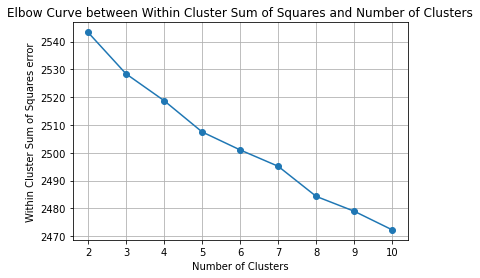

In [29]:
#Plot Elbow Curve

plt.plot(cluster_index, wcss, marker='o')
plt.title("Elbow Curve between Within Cluster Sum of Squares and Number of Clusters")
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares error')
plt.grid(b=True)

print(f'WCSS: \n{wcss}')
print(f'Differences between WCSS values: \n{-np.diff(wcss)}')

In [30]:
print(f'Original categories were : {categories}')

Original categories were : ['comp.windows.x', 'rec.sport.hockey', 'talk.religion.misc']


### Deductions:
1. With the above plot, we can say that the Bending point is observed at K=3, 5 and 8. Hence, the data can be categorized in 3, 5 or 8 clusters.
2. In addition to the above statement, K can be 3 or 8 based on the Silhoutte score as they have the maximum values. 
3. Hence, choosing 3 clusters for more computationally efficient algorithm.

## Testing
### Verifying the Results obtained on a Particular Email data

In [31]:
print(orig_data[1])

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   



In [32]:
def predict_email_cluster(email_number):
    """A function to predict the cluster for any email"""
    print(f"{'#' *40} Original Email Data {'#' *40}")
    print(orig_data[1])
    
    print(f"{'#' *40} Preprocessed Email Data {'#' *40}")
    print(data[email_number])
    
    print('#' *80)      
    X = vectorizer.transform([data[email_number]])
    cluster = model.predict(X)[0]
    print(f"Text belongs to cluster number: {cluster}")
  
    print('#' *80)
    #Printing the Best 10 terms related to the cluster
    print(f'The 10 associated terms within the cluster are given below:')
    print(terms[ind] for ind in order_centroids[cluster, :10])
        
        
    print('#'*80)
    print(f"WordCloud with top 50 words in the Cluster {cluster} are: ")
    freq = frequencies_dict(cluster)
    makeImage(freq)
    print('#'*80)

######################################## Original Email Data ########################################
From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are j

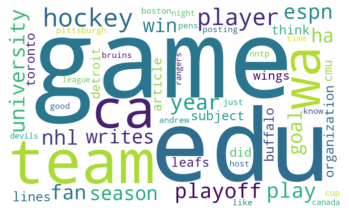

################################################################################


In [33]:
# Testing or predicting on any email
predict_email_cluster(1)

## Future Scope:
1. Once computational power is increased, we can use the whole dataset and get the inferences about the data.
2. Punctuations can be removed.
3. Email Address, Mailing data tags can be removed. Thereby, the words like 'edu', 'com', or 'subject' won't be present in the data
